In [ ]:
import pandas as pd
import numpy as np
import glob #glob 모듈의 glob 함수는 지정한 특정 경로의 파일명을 리스트 형식으로 반환한다.

In [ ]:
# 1) drive 연동
from google.colab import drive
drive.mount('/content/drive/') # 인증 -> Mounted at /content/drive/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# 2) drive 확인 : Mounted as /content/drive
!ls '/content/drive/' # 'MyDrive'

In [ ]:
# 3) directory file 목록 확인 : dataset은 google driver에서 기존에 만듬
!ls -Fcal '/content/drive/MyDrive/dataset'
# -rw------- 1 root root 101690691 Jun 28 13:41 cats_dogs.zip

In [ ]:
# 압축풀기 : 구글 drive에 'cats_dogs' 폴더로 압축파일이 풀린다.
!unzip -qq /content/drive/MyDrive/dataset/cats_dogs.zip  -d /content/drive/MyDrive/dataset/cats_dogs

In [ ]:
Test_root = glob.glob('/content/drive/MyDrive/dataset/cats_dogs/test')[0]
Train_root = glob.glob('/content/drive/MyDrive/dataset/cats_dogs/train')[0]
X_path = glob.glob(Test_root + "/dogs/*")
X_path = X_path + glob.glob(Test_root + "/cats/*")
X_path = X_path + glob.glob(Train_root + "/dog/*")
X_path = X_path + glob.glob(Train_root + "/cat/*")
print(X_path) # ['/content/drive/MyDrive/dataset/cats_dogs/test/cats/cat_110.wav',...

In [ ]:
# 레이블링 : 고양이(0), 강아지(1)

import ntpath # 특정 경로에서 파일들을 가져오는 라이브러리
y = np.empty((0, 1, )) # 비어있는 리스트 만들기

for f in X_path:
    if 'cat' in ntpath.basename(f): #  음성 데이터가 있는 디렉토리의 데이터가 '고양이' 음성 : 0
        resp = np.array([0])  #   [0]
        resp = resp.reshape(1, 1, ) # [[0]]
        y = np.vstack((y, resp))  # 배열을 세로로 결합
    elif 'dog' in ntpath.basename(f): # 음성 데이터가 있는 디렉토리의 데이터가 '강아지' 음성 : 1
        resp = np.array([1])  # [1]
        resp = resp.reshape(1, 1, ) #[[1]]
        y = np.vstack((y, resp)) #
print (y)

In [ ]:
# 데이터셋 나누기
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_path, y, test_size=0.25, random_state=42)
print(len(X_train)) # 186
len(X_test) # 63

In [ ]:
# 오디오 듣기
import IPython.display as ipd
ipd.Audio(X_train[0]) # 강아지

In [ ]:
import librosa #음원 데이터를 분석해주는 라이브러리(음성파일 읽기, 특징 추출)

# 음성파일 읽기 & 디지털 변환 함수
def librosa_read_wav_files(wav_files):
    if not isinstance(wav_files, list): # isinstance(1, int) # 1이 int형인지 알아본다. 결과는 True
        wav_files = [wav_files]
    return [librosa.load(f)[0] for f in wav_files] # 음성파일 읽기

In [ ]:
# 음성파일 읽기 테스트
wav_rate = librosa.load(X_train[0])[1] # 첫번째 동물의 소리 읽기
print(wav_rate) # 22,050Hz : 고양이,강아지의 샘플 비율(1초당 주파수 개수)

In [ ]:
# train/test 음성파일 읽기
X_train2 = librosa_read_wav_files(X_train)
X_test2  = librosa_read_wav_files(X_test)
print(len(X_train2)) # 186
print(len(X_test2)) # 63
print(X_train2[0]) # 디지털 정보 : [-0.00438596 -0.00607391 -0.00652236 ...  0.00694985  0.00674006  0.00268085]


In [ ]:
# 디지털 음파(audio wave) 시각화
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(16,7))
axs[0][0].plot(X_train2[0]) # 강아지 음파
axs[0][1].plot(X_train2[1]) # 고양이 음파
axs[1][0].plot(X_train2[2])
axs[1][1].plot(X_train2[3])
plt.show()

In [ ]:
# 오디오 특징 추출 함수
def extract_features(audio_samples, sample_rate):
    extracted_features = np.empty((0, 41, )) # (1,41) : 41개의 값을 받을 메모리를 할당하겠다는 뜻
    if not isinstance(audio_samples, list):
        audio_samples = [audio_samples]

    for sample in audio_samples:
        zero_cross_feat = librosa.feature.zero_crossing_rate(sample).mean()
        mfccs = librosa.feature.mfcc(y=sample, sr=sample_rate, n_mfcc=40) # 오디오에서 40개 특징 추출
        mfccsscaled = np.mean(mfccs.T,axis=0)  # 각 주파수별 평균값을 구하기
        mfccsscaled = np.append(mfccsscaled, zero_cross_feat)
        mfccsscaled = mfccsscaled.reshape(1, 41, )
        extracted_features = np.vstack((extracted_features, mfccsscaled))
    return extracted_features

In [ ]:
# 오디오 특징 추출
# wave_rate 에 개과 고양이에 속하는 주파수 영역을 주어야 한다.

X_train_features = extract_features(X_train2, wav_rate) # wav_rate=22050(sample_rate)
X_test_features  = extract_features(X_test2, wav_rate) # wav_rate=22050(sample_rate)
print(X_train_features.shape) # (186, 41)
print(X_test_features.shape) # (63, 41)

In [ ]:
from keras import layers
from keras import models
from keras import optimizers
from keras import losses
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.utils import to_categorical

In [ ]:
# y변수 one-hot encoding
train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)
print(test_labels)

In [ ]:
# 신경망 구축
model = models.Sequential()
model.add(layers.Dense(100, activation = 'relu', input_shape = (41, ))) # 입력층 : 41개 오디오 특징
model.add(layers.Dense(50, activation = 'relu'))
model.add(layers.Dense(2, activation = 'softmax'))
model.summary()

In [ ]:
# 학습환경
model.compile(optimizer='adam',
              loss=losses.categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
# 모델 학습
best_model_weights = './base.model'

# https://deep-deep-deep.tistory.com/53
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_acc',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)

callbacks = [checkpoint]

history = model.fit(
    X_train_features,
    train_labels,
    validation_data=(X_test_features,test_labels),
    epochs = 200,
    verbose = 1,
    callbacks=callbacks,
)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


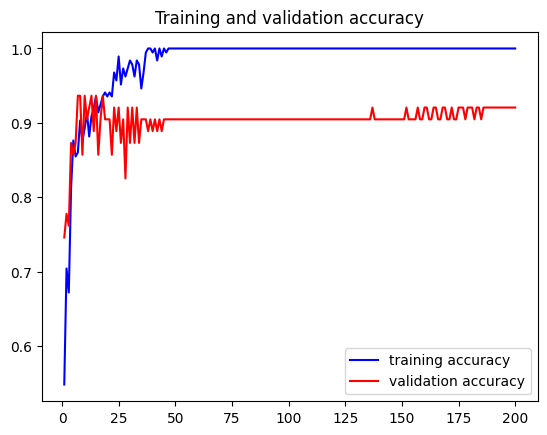

In [ ]:
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'b', label = "training accuracy")
plt.plot(epochs, val_acc, 'r', label = "validation accuracy")
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [ ]:
# 모델 저장
model.save_weights('model_wieghts.h5')
model.save('model_keras.h5')
print('model saved...')

In [ ]:
# 모델 테스트
print(X_test_features.shape) # (63, 41)

import IPython.display as ipd
nr_to_predict = 1 # 두번째 음성
pred = model.predict(X_test_features[nr_to_predict].reshape(1, 41,))
print("Cat: {} Dog: {}".format(pred[0][0], pred[0][1]))

if (y_test[nr_to_predict] == 0):
    print ("This is a cat meowing")
else:
    print ("This is a dog barking")

plt.plot(X_test_features[nr_to_predict])
ipd.Audio(X_test[nr_to_predict],  rate=wav_rate)

In [ ]:
# 모델 테스트
print(X_test_features.shape) # (63, 41)

import IPython.display as ipd
nr_to_predict = 62 # 마지막 음성
pred = model.predict(X_test_features[nr_to_predict].reshape(1, 41,))
print("Cat: {} Dog: {}".format(pred[0][0], pred[0][1]))

if (y_test[nr_to_predict] == 0):
    print ("This is a cat meowing")
else:
    print ("This is a dog barking")

plt.plot(X_test_features[nr_to_predict])
ipd.Audio(X_test[nr_to_predict],  rate=wav_rate)